# Fake News Classification
## _NLP IE HST - Master in Big Data and Business Analytics_ 
### Authors: Bruno Cervantes, Natasha Savic

This notebook will predict fake news comparing different algorithms. The training dataset contains 3999 articles which have been labeled as fake/real news. The algorithms will be trained on the full training set and final predictions will be made on the test dataset for which no labels are available. 

The best score obtained in the pre-training was 0.9383 using Naive Bayes classifier.

In [4]:
#surpress warnings
import warnings
warnings.simplefilter("ignore")

In [5]:
#Importing libraries:
%matplotlib inline
import nltk
from sklearn import metrics
import pandas as pd
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

In [6]:
#Loading the data set - training data.
training_set = pd.read_csv("fake_or_real_news_training.csv", sep=',')

In [7]:
training_set.head()

,ID,title,text,label,X1,X2
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,NaN,NaN


In [8]:
training_set.info()
## We choose to remove both X1 and X2 given the little info they carry. and we need to clean label dropping rows without REAL or FAKE

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 6 columns):
ID       3999 non-null int64
title    3999 non-null object
text     3999 non-null object
label    3999 non-null object
X1       33 non-null object
X2       2 non-null object
dtypes: int64(1), object(5)
memory usage: 187.5+ KB


## Data Preprocessing

After reading the data we will do some preprocessing. By calling the .info() function, we identified that the columns X1 and X2 are usually null except for few rows. After a manual check, it is evident that some labels and text got mixed up in the respective columns.  We will undo this and locate the right information to the right feature and then drop X1 and X2. The reason we chose to drop those columns is that they contain no information and not present in the test dataset.

In [9]:
#Check X1 and X2 and identify which are wrong and get indices
training_set[(training_set.X1.isnull()!=True & (training_set.X2.isnull()==True))].index

Int64Index([ 192,  308,  382,  660,  889,  911, 1010, 1043, 1218, 1438, 1493,
            1591, 1630, 1716, 1900, 1968, 2176, 2493, 2549, 2880, 2920, 3010,
            3069, 3110, 3130, 3210, 3372, 3478, 3578, 3649, 3706],
           dtype='int64')

In [10]:
#Misplaced labels #X1
indices = (192,  308,  382,  660,  889,  911, 1010, 1043, 1218, 1438, 1493,
            1591, 1630, 1716, 1900, 1968, 2176, 2493, 2549, 2880, 2920, 3010,
            3069, 3110, 3130, 3210, 3372, 3478, 3578, 3649, 3706)
for i in indices :
    training_set.iloc[i, 2] = training_set.iloc[i, 3]
    training_set.iloc[i, 3] = training_set.iloc[i, 4]

In [11]:
training_set[training_set.X2.isnull()!=True].index

Int64Index([2184, 3537], dtype='int64')

In [13]:
#Misplaced labels #X2
indices = (2184, 3537)
for i in indices :
    training_set.iloc[i, 2] = training_set.iloc[i, 4]
    training_set.iloc[i, 3] = training_set.iloc[i, 5]

In [14]:
#dropping the columns
training_set = training_set.drop("X1", axis=1)
training_set = training_set.drop("X2", axis=1)

In [15]:
#Final cleanup columns
training_set = training_set[(training_set.label == 'FAKE') | (training_set.label == 'REAL')]

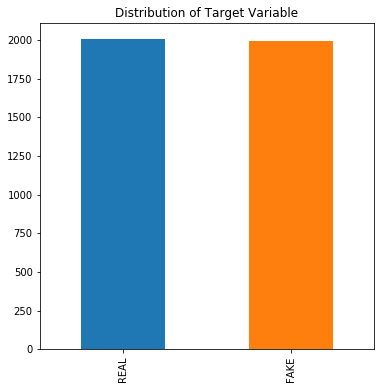

In [16]:
#Check class balance
training_set['label'].value_counts().plot(kind='bar', title="Distribution of Target Variable", figsize=(6,6))

### Concatination and Preparation

Now that we cleaned the data, it needs to be wrangled to be fed into the models. First, we will concatenate the text and title columns so we end up with one text column only. Next, we will binarize the target variable that distinguishes between non-fake and fake news and recodes them into 0 and 1. Before performing the text train split, we will apply stemming in order to normalise the word stems. 

_P.s. we tried some cleaning like e.g. removing punctuation and special characters but it gave us worse results. Our assumption is that bad grammar and unusual characters might serve as attributes that help to identify fake news._

In [19]:
#separating training set into the labels and the data
training_set_labels = training_set.label 
training_set_data = training_set.drop("label", axis = 1)
training_set_data = training_set_data.drop("ID", axis = 1)

In [20]:
#time to merge the title and the text into a single variable: no point in having 2 variables.
training_set_data["full_text"] = training_set_data["title"].map(str) + " " + training_set_data["text"]
training_data = training_set_data["full_text"]

Text(0.5,1,'Title')

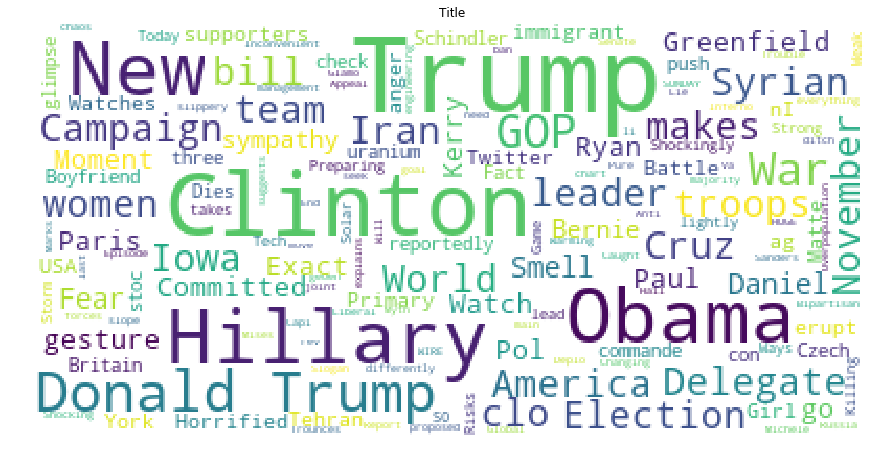

In [22]:
#Get an idea about what words are contained
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=150,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(training_data))
plt.imshow(wordcloud)
plt.rcParams["figure.figsize"] = (16,17)
plt.axis('off')
plt.title("Title")

In [23]:
#turned the labels into list for ease of life
training_labels = training_set_labels.tolist()

In [24]:
labels = [1 if x =='FAKE' else 0 for x in training_labels]

In [25]:
#normalise tokens
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_list = stopwords.words('english')
stemmer = PorterStemmer()
all_tokens_lower = [t.lower() for t in training_data]
tokens_normalised = [stemmer.stem(t) for t in all_tokens_lower
                                     if t not in stop_list]

In [26]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(tokens_normalised, labels,test_size = .3, random_state = 42 )

In [27]:
#transformed the data lists into array so that the model works
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

## Modeling

Let's jump to the most interesting part, the modelling. No specific methodology has been pursued but we tried to test many different classifiers and compared the results. Those are the algorithms we applied:
- Naive Bayes
- SVM
- KNN
- Passive Aggressive
- LSTM ANN

### Naive Bayes

In [28]:
#created a pipeline $ parameters to optimise:
text_clf = Pipeline([('vect', CountVectorizer(stop_words = "english")), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])
parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1, 3)], #test up to 3 n-grams
              'tfidf__use_idf': (True, False), 
              'tfidf__norm': ('l1', 'l2'), 
              'tfidf__sublinear_tf': (True, False), 
              'clf__alpha': (1e-2, 1e-3), 
              'clf__fit_prior':(True, False) }

In [29]:
#create gridsearch using our pipeline as the base function with the parameters created, using ful multicore and cv=5
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, cv=5)

In [30]:
model = gs_clf.fit(X_train, y_train)

In [31]:
model.best_params_

{'clf__alpha': 0.001,
 'clf__fit_prior': True,
 'tfidf__norm': 'l1',
 'tfidf__sublinear_tf': True,
 'tfidf__use_idf': True,
 'vect__ngram_range': (1, 3)}

In [32]:
predicted = model.predict(X_test)

In [33]:
np.mean(predicted == y_test)

0.9383333333333334

### SVM

In [64]:
#SVM Classifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
text_clf_svm = Pipeline([('vect', CountVectorizer(stop_words = "english")), 
                         ('tfidf', TfidfTransformer()), 
                         ('clf-svm', SGDClassifier(loss='hinge', 
                                                   penalty='l2', 
                                                   alpha=1e-3,
                                                   max_iter=200, 
                                                   random_state=42))])
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
              'tfidf__use_idf': (True, False),
              'tfidf__norm': ('l1', 'l2'),
              'tfidf__sublinear_tf': (True, False),
              'clf-svm__alpha': (1e-2, 1e-3)}

In [65]:
#Gridsearch
gs_clf_svm = GridSearchCV(text_clf_svm, parameters_svm, n_jobs=-1, cv=5)
gs_clf_svm = gs_clf_svm.fit(X_train, y_train)
#gs_clf_svm.best_score_
#gs_clf_svm.best_params_

In [67]:
gs_clf_svm.best_params_

{'clf-svm__alpha': 0.001,
 'tfidf__norm': 'l2',
 'tfidf__sublinear_tf': True,
 'tfidf__use_idf': False,
 'vect__ngram_range': (1, 1)}

In [66]:
predicted_svm = gs_clf_svm.predict(X_test)

In [68]:
np.mean(predicted_svm == y_test)

0.8583333333333333

In [ ]:
#Check cross val scores

#from sklearn import metrics
#from sklearn.model_selection import cross_val_score
#cross_val_score(gs_clf_svm, X_train, y_train, cv=5)

### KNN

In [209]:
import sklearn.neighbors

# build classifier
n_neighbors = 3
weights = 'uniform'
weights = 'distance'
clf_knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

In [210]:
#x_train = X_train.reshape(-1, 1)

text_clf_knn = Pipeline([('vect', CountVectorizer(stop_words = "english")), 
                         ('tfidf', TfidfTransformer()), 
                         ('clf-knn', clf_knn)])
gs_clf_knn = text_clf_knn.fit(X_train, y_train)

In [211]:
predicted_knn = gs_clf_knn.predict(X_test)

In [212]:
np.mean(predicted_knn == y_test)

0.8525

### Passive Aggressive

In [34]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.datasets import make_classification

text_clf_PA = Pipeline([('vect', CountVectorizer(stop_words = "english")), ('tfidf', TfidfTransformer()), ('clf_PA', PassiveAggressiveClassifier(random_state=0))])
parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
              'tfidf__use_idf': (True, False),
              'tfidf__norm': ('l1', 'l2'),
              'tfidf__sublinear_tf': (True, False),
              'clf_PA__alpha': (1e-2, 1e-3),
              'clf_PA__fit_prior':(True, False)}

In [35]:
#clf_PA = GridSearchCV(text_clf_PA, parameters, n_jobs=-1, cv=5)
text_clf_PA.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        ...      n_jobs=1, random_state=0, shuffle=True, tol=None, verbose=0,
              warm_start=False))])

In [36]:
predicted_PA = text_clf_PA.predict(X_test)

In [37]:
np.mean(predicted_PA  == y_test)

0.9216666666666666

## Neural Network

In this part we will apply a LSTM neural network. The reason a LSTM has been chosen is that it is commonly used in text classification and yielded the best results. We tested different parameters and dropouts and below is the best result we obtained. Interestingly, Naive Bayes outperformed a LSTM Neural Network. One reason could be the fact that NN performs better on bigger datasets.

### LSTM

In [38]:
# import keras wrapper 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


### Data Preprocessing

In [39]:
#Tokenize - got an error when trying to tokenize directly 
text = training_set['text'].str.split()
title = training_set['title'].str.split()

#Merge title and text into one df
df = text.map(str) + " " + title.map(str)

#turn labels into series as keras works with series
Y = pd.Series(labels)

In [40]:
#Use Keras function to turn text into array
tokenizer = Tokenizer(nb_words=2500, lower=False,split=' ')
tokenizer.fit_on_texts(df.values)
X = tokenizer.texts_to_sequences(df.values)
X = pad_sequences(X)

In [41]:
#Test train split - to avoid confusion we capitalised the last letter for the new train-test split variables
X_traiN, X_tesT, y_traiN, y_tesT = train_test_split(X, Y ,test_size = .1, random_state = 42 )

### LSTM Model

In [49]:
top_words = 35000
max_length = 500
X_traiN = sequence.pad_sequences(X_traiN, maxlen=max_length)
X_tesT = sequence.pad_sequences(X_tesT, maxlen=max_length)
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_length))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) #sigmoid as we have a binary classification problem
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_traiN, y_traiN, validation_data=(X_tesT, y_tesT), epochs=3, batch_size=64)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 32)           1120000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 1,173,301
Trainable params: 1,173,301
Non-trainable params: 0
_________________________________________________________________
None
Train on 3599 samples, validate on 400 samples
Epoch 1/3
3599/3599 [==============================] - 26s 7ms/step - loss: 0.6439 - acc: 0.6363 - val_loss: 0.5542 - val_acc: 0.7675
Epoch 2/3
3599/3599 [==============================] - 27s 8ms/step - loss: 0.

In [50]:
# Final evaluation of the model
scores = model.evaluate(X_tesT, y_tesT, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 85.00%


# Final Predictions

Final predictions are made on the entire training dataset and the final submission will be stored as "predictions.csv".

In [72]:
testing_set = pd.read_csv("fake_or_real_news_test.csv", sep=',')

In [71]:
testing_set_data = testing_set.drop("ID", axis = 1)

In [83]:
testing_set_data["full_text"] = testing_set_data["title"].map(str) + " " + testing_set_data["text"]
test_data = testing_set_data["full_text"]

In [84]:
test_data.head()

0    September New Homes Sales Rise——-Back To 1992 ...
1    Why The Obamacare Doomsday Cult Can't Admit It...
2    Sanders, Cruz resist pressure after NY losses,...
3    Surviving escaped prisoner likely fatigued and...
4    Clinton and Sanders neck and neck in Californi...
Name: full_text, dtype: object

In [85]:
stop_list = stopwords.words('english')
stemmer = PorterStemmer()
all_tokens_lower = [t.lower() for t in test_data]
tokens_normalised1 = [stemmer.stem(t) for t in all_tokens_lower
                                     if t not in stop_list]

In [88]:
final_trainX = np.asarray(tokens_normalised)
final_trainY = np.asarray(labels)
final_testX = np.asarray(tokens_normalised1)

In [89]:
modelfinal = gs_clf.fit(final_trainX, final_trainY)

In [90]:
modelfinal.best_params_

{'clf__alpha': 0.001,
 'clf__fit_prior': False,
 'tfidf__norm': 'l1',
 'tfidf__sublinear_tf': True,
 'tfidf__use_idf': True,
 'vect__ngram_range': (1, 3)}

In [91]:
predictedfinal = model.predict(final_testX)

In [95]:
results =  predictedfinal

In [96]:
#convert labels to original strings
results = ['FAKE' if x ==1 else 'REAL' for x in results]

In [98]:
results_final = pd.DataFrame(results, columns=['labels'])

In [100]:
dataframefinal = pd.concat([testing_set, results_final], axis=1)

In [102]:
dataframefinal = dataframefinal.drop("title", axis = 1)
dataframefinal = dataframefinal.drop("text", axis = 1)

In [104]:
dataframefinal.to_csv('predictions.csv', index = False)

# Conclusion

In this notebook, we built a predictor to classify fake news. The dataset containsed3999 observations which have been preprocessed and fed into different algorithms. The best result we obtained was 0.9383 using Naive Bayes and k=5 cross-validation. Final predictions have been derived from the test dataset from the Naive Bayes Classifier which has been trained on the entire dataset. Our final submission can be found in the folder as "predictions.csv" file.

Thank you for reading!